# Research Skills: Image Analysis 
## Take-home Assignment - Part 2 
Sharon Ong, Department of Cognitive Science and Artificial Intelligence 

Tilburg University
Blok 3, Spring 2024

Your First Name: Daniel

Your Last Name: Koltai

Your Student ID: 2123303

Please include any special instructions to run your code, references to any code, methods, ideas that are not your own or not provided in this course here. 

**Note**
- To set up the specific environment in which the notebook solutions were prodecud I attached the file environment.yml <br>
This file contains the dependencies to recreate the same environment (with conda) for running the notebook
- Code snippets from the tutorial notebooks were incorporated for some of the solutions.

## Part 2: Processing an image of coins

1. (2 points) Load the image of coins you have been provided and display it with an appropriate title.

In [1]:
from skimage import io
from matplotlib import pyplot as plt

im = io.imread("files/2123303.zip/2123303_coinimage.jpg")
plt.figure(figsize=(5,5))
plt.imshow(im)
plt.axis('off')
plt.title('Coin Image')

Text(0.5, 1.0, 'Coin Image')

2. (20 points) SSegment the coins to obtain a binary image where pixels representing the coins are set to 1.
You should compare two different image segmentation algorithms and you can apply image enhancement
techniques and morphological operations on these imagese..

   **Report the steps you took to compute two image segmentation algorithms as comments in your code. Display the results of image processing at each step with appropriate title

Possible segmentation techniques include Thresholding, Edge Detection, Hough Transforms, Superpixels 
and Graphcuts. Comparing two thresholding algorithms only count as 1 method. The morphologica 
operations are seen as pre or post processing operations. You can combine different techniques. For
example, you can combine Thresholding with morphological operations and histogram equalization as
one solution and Edge detection followed by morphological operations as another solution.s.**

#### Exploring the image

As the output shows the image is already normalized

#### Image Preprocessing

Image Preprocessing steps taken

0. Exploration of the image

- Observing histograms for all color channel
- The image is already normalized in all channels
- The code is not displayed here to keep the notebook clear

1. Contrast and Histogram adjustment

- Contrast stretching, Histogram equalization and Adaptive histrogam equalization was applied on the image.
- Contrast stretching provided the best results for enhancing the image for further processing

2. Grayscale conversion

3. Noise removal

- Median filter with a structuring element of disk of radius 3 yielded the best result
- Gaussian blur operation with several parameters was tested too


Text(0.5, 0.98, 'Image preprocessing steps')

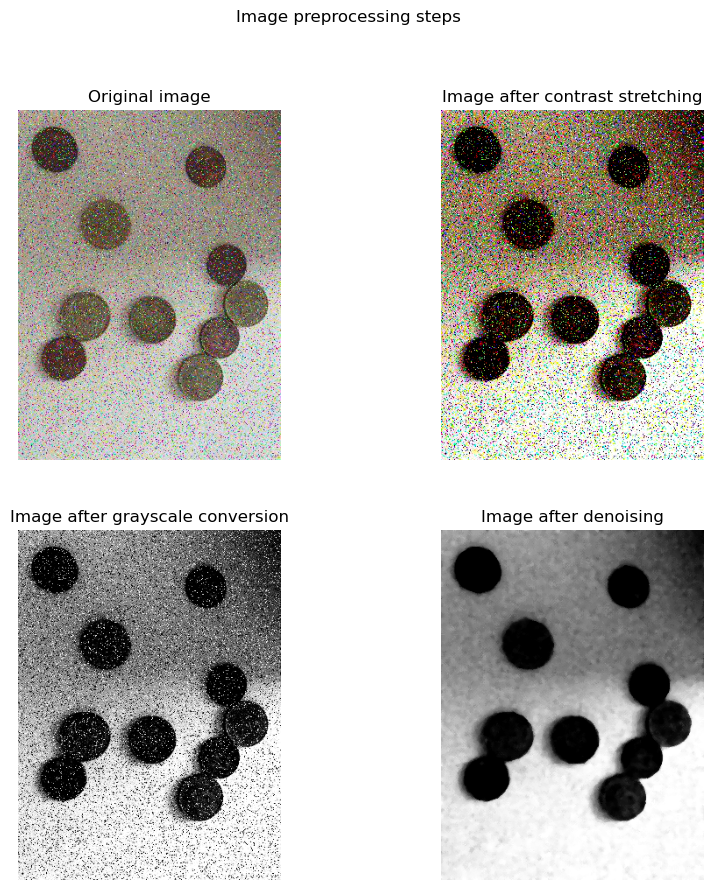

In [2]:
# contrast stretching 
import numpy as np
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import median

p2 = np.percentile(im, 20) 
p98 = np.percentile(im, 80) 
im_rescale = exposure.rescale_intensity(im, in_range=(p2, p98))

# grayscale conversion
from skimage import color
im_rescale_gray = color.rgb2gray(im_rescale)

# denoising
im_rescale_denoise = median(im_rescale_gray, disk(3))

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(im)
plt.axis('off')
plt.title('Original image')
plt.subplot(222)
plt.imshow(im_rescale)
plt.axis('off')
plt.title('Image after contrast stretching')
plt.subplot(223)
plt.imshow(im_rescale_gray, cmap='gray')
plt.axis('off')
plt.title('Image after grayscale conversion')
plt.subplot(224)
plt.imshow(im_rescale_denoise, cmap='gray')
plt.axis('off')
plt.title('Image after denoising')
plt.suptitle('Image preprocessing steps')

#### Approach 1: Tresholding and morphological operations

- Multiple tresholding methods were applied
- Local tresholding yielded the best result in separating the darker coins from the lighter background (in binary color map coins were white and background is black)
- Blocksize (351) and offset (0.25) parameters were manually tuned
- To correct the shape by making them more circular and smooth and to shrunk connection between touching coins morphological operations of dilation and erosion were applied

Text(0.5, 0.98, 'Segmentation steps of the coin image')

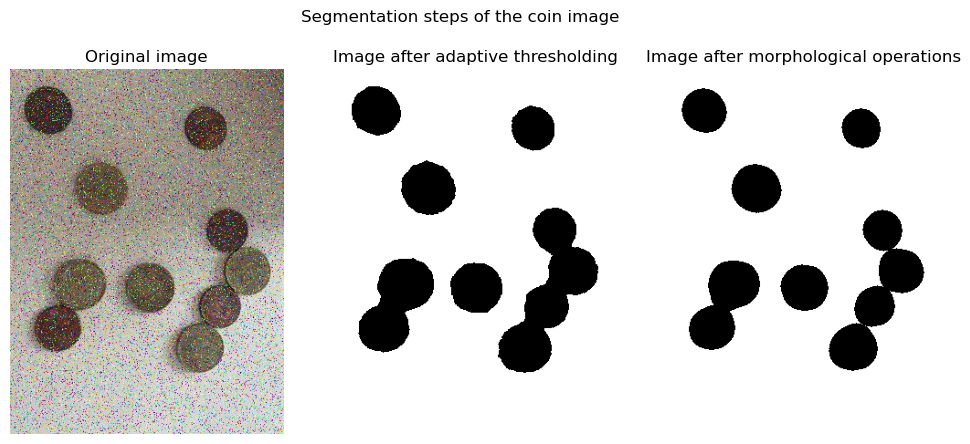

In [3]:
from skimage.filters import threshold_local

# adaptive thresholding
block_size = 351
# get adaptive threshold
adaptive_threshold = threshold_local(im_rescale_denoise, block_size, offset=0.25)
# apply threshold on the image
im_tresh_adaptive = im_rescale_denoise < adaptive_threshold

from skimage.morphology import binary_dilation, binary_erosion
from skimage.morphology import disk

# morphological operations to obtain better shape of the coins segmentation
im_tresh_adaptive_morph = binary_erosion(im_tresh_adaptive, disk(20))
im_tresh_adaptive_morph = binary_dilation(im_tresh_adaptive_morph, disk(18))

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(im)
plt.axis('off')
plt.title('Original image')
plt.subplot(132)
plt.imshow(im_tresh_adaptive, cmap='binary')
plt.axis('off')
plt.title('Image after adaptive thresholding')
plt.subplot(133)
plt.imshow(im_tresh_adaptive_morph, cmap='binary')
plt.axis('off')
plt.title('Image after morphological operations')
plt.suptitle('Segmentation steps of the coin image')

#### Approach 2 - Hough transform

Hough transfrom for circle detection was applied after grayscale conversion and denosing (median filter, disk of radius 4) of the original image.

Text(0.5, 0.98, 'Image preprocessing steps')

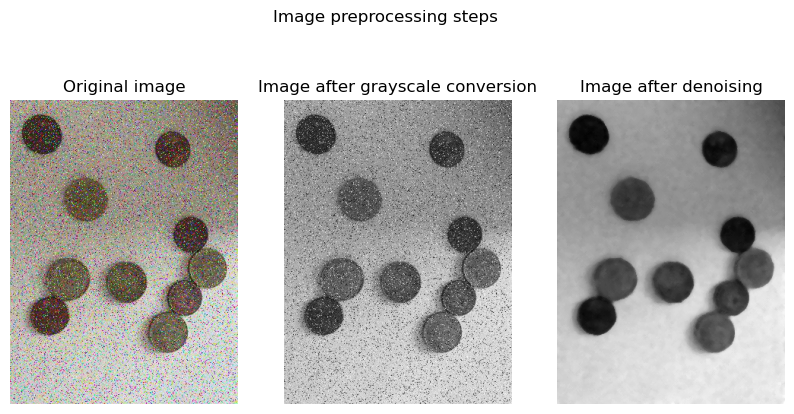

In [4]:
# Image preprocessing
from skimage.morphology import disk
# grayscale conversion
im_gray = color.rgb2gray(im)
# denoising with median filter with structuring element disk of radius 4
im_denoised = median(im_gray, disk(4))

plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(im, cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.subplot(132)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Image after grayscale conversion')
plt.subplot(133)
plt.imshow(im_denoised, cmap='gray')
plt.axis('off')
plt.title('Image after denoising')
plt.suptitle('Image preprocessing steps')

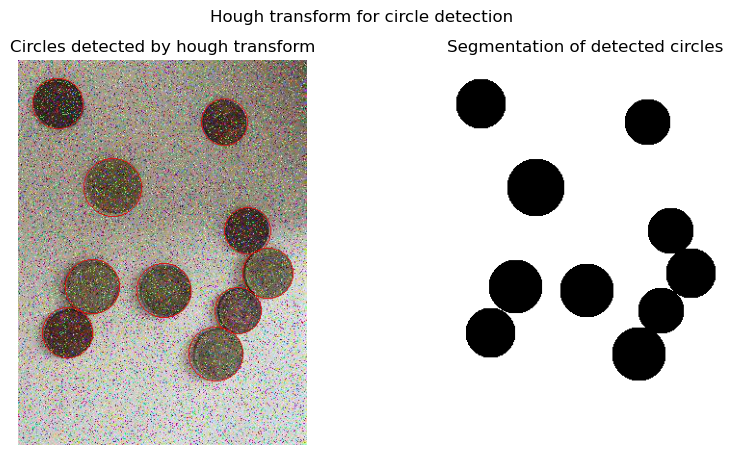

In [5]:
# Hough transform for circle detection

from skimage.util import img_as_ubyte
from skimage import feature
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

# Take the denoised image and detect edges
image = im_denoised
image = img_as_ubyte(im_denoised)
edges = feature.canny(image, sigma=3, low_threshold=10, high_threshold=50)

# Detect two radii
hough_radii = np.arange(20, 35, 2)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 10 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=10)

# Overlay the found circles over the original image
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    im[circy, circx] = (220, 20, 20)

ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Circles detected by hough transform')


# Select pixels corresponding to the detected circles
# this code was in part created with github copilot
from skimage.draw import disk

# Create a new image filled with zeros
im_hough = np.zeros(image.shape, dtype=np.uint8)

# For each circle
for center_y, center_x, radius in zip(cy, cx, radii):
    # Generate the coordinates of all pixels within the circle
    circy, circx = disk((center_y, center_x), radius, shape=image.shape)
    # Set the corresponding pixels in the new image to 1
    im_hough[circy, circx] = 1

# transfrom image from uint8 to bool
im_hough = im_hough.astype(bool)

# plt.subplot(ncols=2, nrows=1, figsize=(10, 5))
ax[1].imshow(im_hough, cmap='binary')
ax[1].axis('off')
ax[1].set_title('Segmentation of detected circles')
fig.suptitle('Hough transform for circle detection')
plt.show()

# reload im as it was changed
im = io.imread("files/2123303.zip/2123303_coinimage.jpg")


#### Comparison of approaches

ration of pixels
differently selected by approaches 2.66%
only selected by approach 1:  2.44%
only selected by approach 2:  0.22%
selected by both approaches:  2.66%


Text(0.5, 0.98, 'Comparison of the two segmentations')

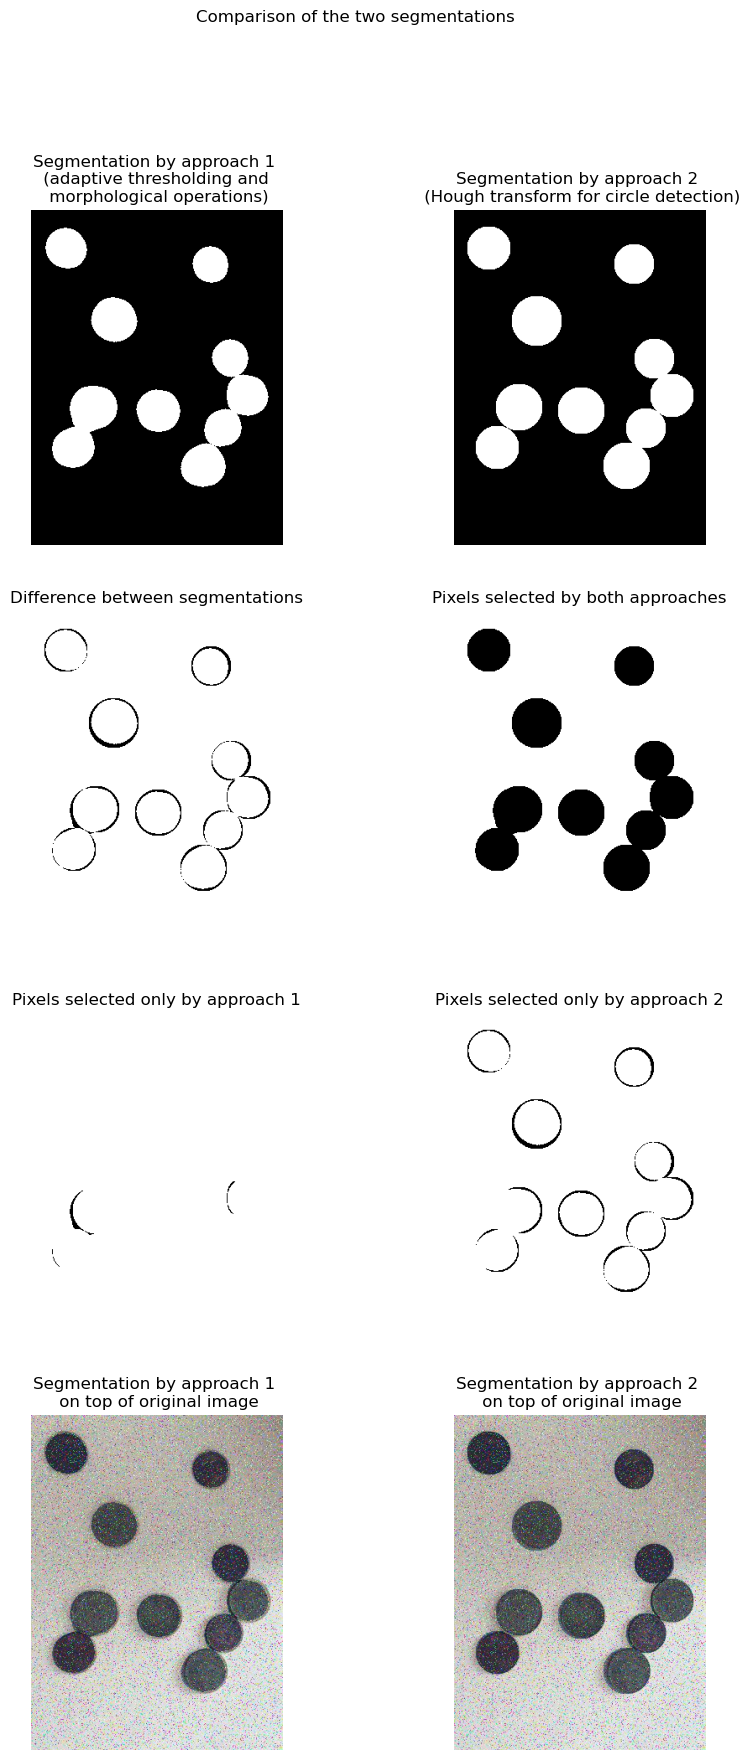

In [6]:
# To compare the segmentation done by the two approaches
# Calculate the difference between the two segmentations 
# Set matching pixels to 0 (white) and differing pixels to 1 (black)

diff = (im_tresh_adaptive_morph ^ im_hough)
both = ((im_tresh_adaptive_morph == 1) & (im_hough == 1))
only1_tresh_adaptive_morph = (im_tresh_adaptive_morph == 1) & ( im_hough == 0)
only1_hough = (im_tresh_adaptive_morph == 0) & (im_hough == 1)

# calculate ration of differing pixels from the total number of pixels of the image
total_pixels = diff.size

print("ration of pixels")
print("differently selected by approaches {:.2%}".format( np.sum(diff) / total_pixels ))
print("only selected by approach 1:  {:.2%}".format( np.sum(only1_hough) / total_pixels ) )
print("only selected by approach 2:  {:.2%}".format( np.sum(only1_tresh_adaptive_morph) / total_pixels ) )
print("selected by both approaches:  {:.2%}".format( np.sum(diff) / total_pixels) )

plt.figure(figsize=(10, 20))
plt.subplot(421)
plt.imshow(im_tresh_adaptive_morph, cmap='gray')
plt.axis('off')
plt.title('Segmentation by approach 1 \n (adaptive thresholding and \n morphological operations)')
plt.subplot(422)
plt.imshow(im_hough, cmap='gray')
plt.axis('off')
plt.title('Segmentation by approach 2 \n (Hough transform for circle detection)')
plt.subplot(423)
plt.imshow(diff, cmap='binary')
plt.axis('off')
plt.title('Difference between segmentations')
plt.subplot(424)
plt.imshow(im_tresh_adaptive_morph + im_hough, cmap='binary')
plt.axis('off')
plt.title('Pixels selected by both approaches')
plt.subplot(425)
plt.imshow( only1_tresh_adaptive_morph, cmap='binary')
plt.axis('off')
plt.title('Pixels selected only by approach 1')
plt.subplot(426)
plt.imshow( only1_hough, cmap='binary')
plt.axis('off')
plt.title('Pixels selected only by approach 2')

# display segmentation on top of original image
plt.subplot(427)
plt.imshow(im, alpha=1)
plt.imshow(im_tresh_adaptive_morph, cmap='Blues', alpha=0.3)
plt.axis('off')
plt.title('Segmentation by approach 1 \n on top of original image')
plt.subplot(428)
plt.imshow(im, alpha=1)
plt.imshow(im_hough, cmap='Blues', alpha=0.3)
plt.axis('off')
plt.title('Segmentation by approach 2 \n on top of original image')

plt.suptitle('Comparison of the two segmentations')



- Both segmentations capture the coins very closely. Both segmentations maintain smooth and round coin like shapes.
- Both segmentations appears to have selected all pixels corresponding to the coins, and they also selected a very small amount of pixels lying just next to the coins.
- The 2nd approach selected slightly more pixels than the first
- It depends on the applications that which segmentation is better, as they are really closely matching.


3. (5 points) Sets of white pixels which are connected to each other are called connected components or objects. Using your best segmentation result from Q2A.2, create code to connect all the connected components and visualize each connected component with a different color overlaid on the original image*

- From now on the segmentation obtained though hough transfrom will be used

Text(0.5, 1.0, 'Image with labelled connected components')

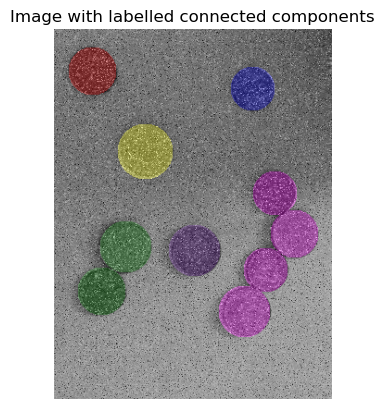

In [7]:
from skimage.measure import label
from skimage.color import label2rgb

# label connected components
labels = label(im_hough)
# create overlay of labels on top of original image
image_label_overlay = label2rgb(labels, image=im)

plt.imshow(image_label_overlay)
plt.axis('off')
plt.title('Image with labelled connected components')

4. (10 points) Using your best segmentation result from Q2A.2, separate the touching coins and visualize each coin with a different color overlaid on the original image. Report the steps you took as comments in your code.

Text(0.5, 0.98, 'Separating touching coins and labelling them')

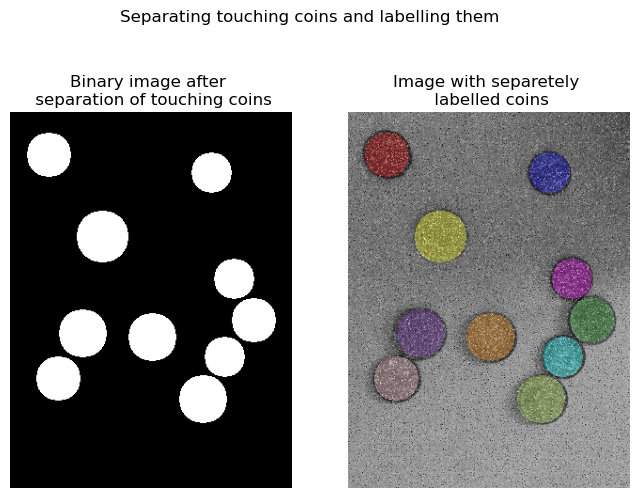

In [8]:
# separate touching coins by applying large erosion and then large dilation
# the separation obtained by this approach is better that just simply applying erosion
# as that approach requires higher distortion of the segmentation to separate the coins
from skimage.morphology import disk

im_segmented_morph = binary_erosion(im_hough, disk(20))
im_segmented_morph = binary_dilation(im_segmented_morph, disk(18))

# label the connected components
labels = label(im_segmented_morph)

# overlay the labels on the original image
image_label_overlay = label2rgb(labels, image=im)

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(im_segmented_morph, cmap='gray')
plt.axis('off')
plt.title('Binary image after \n separation of touching coins')
plt.subplot(122)
plt.imshow(image_label_overlay)
plt.axis('off')
plt.title('Image with separetely \n labelled coins')

plt.suptitle('Separating touching coins and labelling them')

5. (5 points) Show your original image with an overlay of bounding boxes or circular boundaries of each coin you found. You can use the segmentation results (from Q2A.2) or the original imagee.

   **Display the resulting images with appropriate titles. Print the number of coins. Report the steps you took as comments in your code.**

In [9]:
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches

# Label the connected components
labels = label(im_segmented_morph)
# Get the properties of the labeled regions
props = regionprops(labels)

fig, ax = plt.subplots()
ax.imshow(im)
# For each region, draw a rectangle or circle
for region in props:
    # Draw a circle
    # Code drawing circle was partly created with github copilot
    if region.equivalent_diameter is not None:
        circ = mpatches.Circle((region.centroid[1], region.centroid[0]), region.equivalent_diameter / 2, fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(circ)
    
# Show the result
ax.set_axis_off()
plt.title('Detected coins')
plt.show()

print("The number of detected coins is: ", len(props))

The number of detected coins is:  10


6. (8 points) The image contains 5 cents and 50 cents. Indicate the amount of money your code finds in the image. Show your original image with an overlay of green points on the centroids of 5 cents and red points on the centroids of 50 cents.
   **Display the resulting images with appropriate titles. Print the amount of money in the image. Report the steps you took as comments in your code.**

- From each region corresponding to a coin the mean hue value of pixels was exracted.<br>
The mean hue value of the coins should be different since 50 cents are gold coloured 5 cent are copper coloured.
- The extracted hue values were then clustered into two classes by kMeans clustering.<br>
Coins corresponding to one class were marked with blue dots, coins of the other class were marked with red dots.
- To sum the value of cash on the picture, 50 cents which belongs to class 1 were added and 5 cents which belongs to class 0 were added with their corresponding values.

- The radius of the regions corresponding to the coins were not good enough to determine coin types. Due to distortion of shapes coming from the wide angle and short distance of the taken image, coin radiuses are smaller when the coin is close to the center and larger when its close to the sides of the image. Thus I choose an other attribute of the coins, mean hue; which was clearly distinguishing coin types.

In [10]:
from skimage.measure import label, regionprops
from skimage.color import rgb2hsv
import numpy as np

# For each region, calculate the mean hue value of pixels in the region
hues = []
for region in props:
    region_pixels = rgb2hsv(im)[:,:,0][labels == region.label]
    mean_color = np.mean(region_pixels, axis=0)
    hues.append(mean_color)

# Convert hues list to a numpy array, normalize, reshape
hues_array = np.array(hues)
hues_array = (hues_array - hues_array.min()) / (hues_array.max() - hues_array.min())
hues_array = hues_array.reshape(-1, 1)

# Create a KMeans object with 2 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
# Fit the KMeans object to the data
kmeans.fit(hues_array)
# Get the labels of the clusters
class_labels = kmeans.labels_

# Plot image with markers of coins corresponding to their class (50c, 5c)
fig, ax = plt.subplots()
ax.imshow(im)
# plot markers at the centroids if label is 0 plot blue marker if class_label is 1 plot red marker:
for region, label in zip(props, class_labels):
    ax.plot(region.centroid[1], region.centroid[0], 'o', markerfacecolor='blue' if label == 0 else 'red', markersize=10)

# count cash by iterating through class_labels and adding 0.50 for 50c and 0.05 for 5c
total_cash = 0
for i in class_labels:
    # 50c coins
    if i == 0:
        total_cash += 0.50
    # 5c coins
    else:
        total_cash += 0.5

plt.title('Total value of coins in the image: ${:.2f}'.format(total_cash) + '\n \n coins marked with blue are 50c \n  and coins marked with red are 5c \n ')
plt.axis('off')
plt.show()

/home/danaconda/miniconda3/envs/ima/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
